<a href="https://colab.research.google.com/github/caesarcc/pucminas-tcc-fake-news-detection/blob/main/passo05_teste_do_modelo_treinado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Teste do Modelo Treinado

### Iniciando pela configuração do Google Colab

In [1]:
!pip install -q transformers

     |████████████████████████████████| 4.4 MB 13.9 MB/s 
     |████████████████████████████████| 596 kB 88.0 MB/s 
     |████████████████████████████████| 101 kB 14.5 MB/s 
     |████████████████████████████████| 6.6 MB 59.7 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importação de bibliotecas utilizadas no treino e avaliação
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from IPython.display import display
from sklearn.metrics import (auc, classification_report, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve)
from torch.utils.data import (DataLoader, TensorDataset)
from transformers import (AutoModelForSequenceClassification, AutoTokenizer)
from transformers.file_utils import is_torch_available
from scipy.special import softmax

In [4]:
#Configurações de ambiente
%matplotlib inline
# limites de impressão para o pandas
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 250)
# configura tema dos gráficos
sns.set_theme(style="white")
#configura a barra de progressos para usar no apply

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Carrega dataset de teste

In [5]:
dados_teste = pd.read_csv(r'/content/drive/MyDrive/PUC/TCC/dados/dataset_teste.csv', sep = ',')
dados_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LABELS            1341 non-null   int64 
 1   texto_lematizado  1341 non-null   object
 2   TOKENS            1341 non-null   object
dtypes: int64(1), object(2)
memory usage: 31.6+ KB


### Carrega modelo e tokenizador já treinado

In [6]:
MODELO_LOCAL = "/content/drive/MyDrive/PUC/TCC/modelos/classificador_bertimbau"

tokenizer = AutoTokenizer.from_pretrained(MODELO_LOCAL, do_lower_case=False)
model_bert = AutoModelForSequenceClassification.from_pretrained(MODELO_LOCAL, num_labels=2)
model_bert.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Gera o dataloader de teste

In [7]:
dados_teste['TOKENS'] = dados_teste['texto_lematizado'].apply(
    lambda x: np.array(
        tokenizer.encode(x, padding='max_length', 
                         truncation=True, max_length=300)))
lote_tamanho = 4
# gera dataset e leitor de dados de validação
teste_dados = TensorDataset(
    torch.tensor(np.array(dados_teste['TOKENS'].to_list())).to(device), 
    torch.tensor(np.array(dados_teste['LABELS'].values)).to(device))
teste_leitor = DataLoader(teste_dados, batch_size=lote_tamanho, shuffle=True)

### Teste do Modelo tunado

In [54]:
classes_previstas , classes_verdadeiras = [], []
for lote in teste_leitor:
    # coloca o lote na GPUS
    lote = tuple(t.to(device) for t in lote)
    lote_valores, lote_classes = lote
    with torch.no_grad():
        outputs = model_bert(lote_valores)
    # Salva as predições e as classes corretos
    classes_previstas.append(outputs.logits.detach().cpu().numpy())
    classes_verdadeiras.append(lote_classes.to('cpu').numpy()) 

In [122]:
# prepara resultado
lista_previsoes_soft = softmax(np.concatenate(classes_previstas, axis=0), axis=1)
lista_previsoes = np.argmax(lista_previsoes_soft, axis=1).flatten()
lista_classes_verdadeiras = np.concatenate(classes_verdadeiras, axis=0)

# seleciona confidence score de %70
lista_previsoes_threshold = lista_previsoes_soft > [0.70, 0.30]
lista_previsoes_threshold = np.argmax(lista_previsoes_threshold, axis=1).flatten()

### Relatório de classificação

In [ ]:
print(classification_report(
    lista_classes_verdadeiras, 
    lista_previsoes,target_names=['confiável','falso']))

              precision    recall  f1-score   support

   confiável       0.94      0.99      0.97       675
       falso       0.99      0.94      0.96       666

    accuracy                           0.96      1341
   macro avg       0.97      0.96      0.96      1341
weighted avg       0.97      0.96      0.96      1341



### Matriz de confusão

[[667   8]
 [ 40 626]]


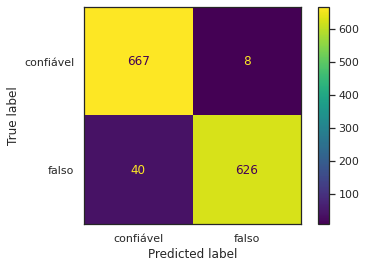

In [ ]:
conf = confusion_matrix(lista_classes_verdadeiras, lista_previsoes)
print(conf)
cmd = ConfusionMatrixDisplay(conf, display_labels=['confiável','falso'])
cmd.plot()

[[623  27]
 [ 11 680]]


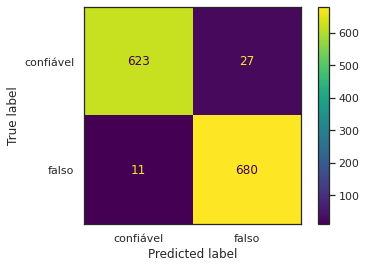

In [108]:
conf = confusion_matrix(lista_classes_verdadeiras, lista_previsoes_threshold)
print(conf)
cmd = ConfusionMatrixDisplay(conf, display_labels=['confiável','falso'])
cmd.plot()

### Curva ROC
Receiver Operating Characteristic Curve

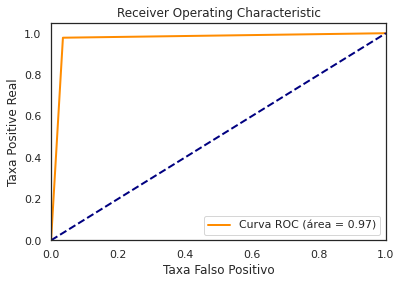

In [138]:
axis=-1
fpr, tpr, _ = roc_curve(lista_classes_verdadeiras, lista_previsoes)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa Falso Positivo')
plt.ylabel('Taxa Positive Real')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()